# Extract annotation information from TCDB

Purpose of this notebook is to extract and format TCDB data for subsequent model annotation. Additionally, extract data for transport protein classification.

Note: Requires internet connection to download information from [Transport Classification Database (TCDB)](https://www.tcdb.org/).

### Citation
Saier MH, Reddy VS, Moreno-Hagelsieb G, Hendargo KJ, Zhang Y, Iddamsetty V, Lam KJK, Tian N, Russum S, Wang J, Medrano-Soto A. The Transporter Classification Database (TCDB): 2021 update. Nucleic Acids Res. 2021 Jan 8;49(D1):D461-D467. doi: 10.1093/nar/gkaa1004. PMID: 33170213; PMCID: PMC7778945.

## Setup
### Import packages

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from rbc_gem_utils import (
    ANNOTATION_PATH,
    DATABASE_PATH,
    GEM_NAME,
    INTERIM_PATH,
    ROOT_PATH,
    build_string,
    compare_tables,
    explode_column,
    get_annotation_df,
    read_rbc_model,
    show_versions,
    visualize_comparison,
)
from rbc_gem_utils.database.tcdb import TCDB_DB_TAG, TCDB_PATH, download_database_TCDB

# Display versions of last time notebook ran and worked
show_versions()


Package Information
-------------------
rbc-gem-utils 0.0.1

Dependency Information
----------------------
beautifulsoup4                       4.12.3
bio                                   1.6.2
cobra                                0.29.0
depinfo                               2.2.0
kaleido                               0.2.1
matplotlib                            3.8.2
memote                               0.17.0
networkx                              3.2.1
notebook                              7.0.7
openpyxl                              3.1.2
pandas                                2.2.0
pre-commit                            3.6.0
pyvis                                 0.3.2
rbc-gem-utils[database,network,vis] missing
requests                             2.31.0
scipy                                1.12.0
seaborn                              0.13.2

Build Tools Information
-----------------------
pip        23.3.1
setuptools 68.2.2
wheel      0.41.2

Platform Information
-------------------

## Check TCDB version
If the version does not match the expected version, it is because database has been updated since the last time this code was utilized. 

### Last update: Feb. 4th, 2024
* According to the [TCDB FAQ](https://www.tcdb.org/faq.php), updates are usually every week, but it mainly depends on the availability of new data.

In [2]:
database_dirpath = ROOT_PATH / DATABASE_PATH / TCDB_PATH
annotation_dirpath = ROOT_PATH / ANNOTATION_PATH

## Set notebook options

In [3]:
compare_figsize = (5, 5)
overwrite = True
display_nunique = True
compare = True
db_tag = TCDB_DB_TAG

#### Download new files and update database

In [4]:
download = True
if download:
    download_database_TCDB(database_dirpath=database_dirpath)

## Load RBC-GEM model

In [5]:
model = read_rbc_model(filetype="xml")
model

Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-21


Name,RBC_GEM
Memory address,1534e7d50
Number of metabolites,2157
Number of reactions,3275
Number of genes,820
Number of groups,78
Objective expression,1.0*NaKt - 1.0*NaKt_reverse_db47e
Compartments,"cytosol, extracellular space"


In [6]:
annotation_type = "genes"
annotation_cols = ["tcdb", "uniprot"]
# TCDB is best if all mappings are up to date, UniProt may not work if TCDB maps to a secondary accession
mapping_key = "uniprot"

df_model_mappings = (
    get_annotation_df(model.genes, annotation_cols)
    .rename({"id": annotation_type}, axis=1)
    .dropna(subset=[mapping_key])
)

for col in df_model_mappings.columns:
    df_model_mappings = explode_column(df_model_mappings, name=col, sep=";")
df_model_mappings = df_model_mappings.sort_values(annotation_type)

print(df_model_mappings.nunique(dropna=True))
df_model_mappings = df_model_mappings.reset_index(drop=True)
df_model_mappings

genes      820
tcdb       150
uniprot    820
dtype: int64


,genes,tcdb,uniprot
0,A4GALT,<NA>,Q9NPC4
1,AARS1,<NA>,P49588
2,AASDHPPT,<NA>,Q9NRN7
3,ABCA1,3.A.1.211.14,O95477
4,ABCA7,3.A.1.211.10,Q8IZY2
...,...,...,...
820,YES1,<NA>,P07947
821,ZDHHC2,<NA>,Q9UIJ5
822,ZDHHC20,8.A.114.1.6,Q5W0Z9
823,ZDHHC3,<NA>,Q9NYG2


### Load identifier tables

In [7]:
df_accessions = pd.read_csv(
    database_dirpath / "acc2tcid.tsv",
    sep="\t",
    header=None,
    names=["uniprot", "tcdb"],
    on_bad_lines="error",
    dtype=str,
)
df_families = pd.read_csv(
    database_dirpath / "families.tsv",
    sep="\t",
    header=None,
    names=["Family", "fam_name"],
    on_bad_lines="error",
    dtype=str,
)
df_superfamilies = pd.read_csv(
    database_dirpath / "listSuperfamilies.tsv",
    sep="\t",
    on_bad_lines="warn",  # Known issue line:7723, field is duplicated so its okay to skip.
    dtype=str,
)

df_families = df_families.merge(
    df_superfamilies,
    left_on="Family",
    right_on="Family",
    how="outer",
).drop_duplicates()
df_families = df_families.rename({c: c.lower() for c in df_families.columns}, axis=1)
df_families

/var/folders/5t/hk8m3g6d1jn25x5rssjgsrmm0000gn/T/ipykernel_39276/2582757712.py:17: ParserWarning: Skipping line 8018: expected 5 fields, saw 6

  df_superfamilies = pd.read_csv(


,family,fam_name,#tcid,subfamily,fam_abbreviation,superfamily
0,1.A.1,The Voltage-gated Ion Channel (VIC) Superfamily,1.A.1.1.1,1.A.1.1,VIC,VIC Superfamily
1,1.A.1,The Voltage-gated Ion Channel (VIC) Superfamily,1.A.1.10.1,1.A.1.10,VIC,VIC Superfamily
2,1.A.1,The Voltage-gated Ion Channel (VIC) Superfamily,1.A.1.10.10,1.A.1.10,VIC,VIC Superfamily
3,1.A.1,The Voltage-gated Ion Channel (VIC) Superfamily,1.A.1.10.11,1.A.1.10,VIC,VIC Superfamily
4,1.A.1,The Voltage-gated Ion Channel (VIC) Superfamily,1.A.1.10.12,1.A.1.10,VIC,VIC Superfamily
...,...,...,...,...,...,...
12759,9.C.5,The Endoplasmic Reticulum/Golgi ATP/ADP or AMP...,NaN,NaN,NaN,NaN
12760,9.C.6,The Mitochondrial Organic Anion Channel (MOAC)...,NaN,NaN,NaN,NaN
12761,9.C.7,"The Low-affinity, Calcium-blocked, Nonspecific...",NaN,NaN,NaN,NaN
12762,9.C.8,The ABC Lignin Precursor Transporters (ALPT) F...,NaN,NaN,NaN,NaN


### Create data table

In [8]:
df_model_tcdb = df_model_mappings.merge(
    df_accessions,
    left_on=mapping_key,
    right_on=mapping_key,
    how="left",
    suffixes=("_MODEL", ""),
)
df_model_tcdb = df_model_tcdb.drop(
    labels=[x for x in df_model_tcdb.columns if x.endswith("_MODEL")], axis=1
)
df_model_tcdb = df_model_tcdb.dropna().drop_duplicates().reset_index(drop=True)

df_model_tcdb = (
    df_model_tcdb.merge(
        df_families,
        left_on="tcdb",
        right_on="#tcid",
        how="left",
    )
    .rename({c: c.lower() for c in df_families.columns}, axis=1)
    .drop("#tcid", axis=1)
)

for filename in ["pfam", "refseq", "pdb", "go", "getSubstrates"]:
    if filename == "getSubstrates":
        df = pd.read_csv(
            database_dirpath / f"tcdb_{filename}.tsv",
            sep="\t",
            header=None,
            names=["tcdb", "chebi"],
        )
        df["chebi"] = df["chebi"].str.split("|")
        df["substrate"] = df["chebi"].apply(
            lambda x: build_string([s.split(";")[-1] for s in x])
        )
        df["chebi"] = df["chebi"].apply(
            lambda x: build_string([s.split(";")[0] for s in x])
        )

    else:
        df = pd.read_csv(
            database_dirpath / f"tcdb_{filename}.tsv",
            sep="\t",
            header=None,
            names=[filename, "tcdb", "family"],
        ).drop("family", axis=1)

    df_model_tcdb = df_model_tcdb.merge(
        df.set_index("tcdb"),
        left_on="tcdb",
        right_on="tcdb",
        how="left",
    ).reset_index(drop=True)

df_model_tcdb = (
    df_model_tcdb.groupby(["genes", "tcdb", "uniprot"], as_index=False)
    .agg(lambda x: build_string(list(x.dropna().unique())))
    .drop_duplicates()
)
df_model_tcdb["subfamily"] = (
    df_model_tcdb["tcdb"].str.findall(r"^\w+\W\w+\W\w+\W\w+").explode()
)
df_model_tcdb["family"] = df_model_tcdb["tcdb"].str.findall(r"^\w+\W\w+\W\w+").explode()
df_model_tcdb["subclass"] = df_model_tcdb["tcdb"].str.findall(r"^\w+\W\w+").explode()
df_model_tcdb["class"] = df_model_tcdb["tcdb"].str.findall(r"^\w+").explode()
df_model_tcdb = df_model_tcdb.loc[
    :,
    [
        "genes",
        "uniprot",
        "tcdb",
        "subfamily",
        "family",
        "subclass",
        "class",
        "fam_name",
        "fam_abbreviation",
        "superfamily",
        "pfam",
        "refseq",
        "pdb",
        "go",
        "chebi",
        "substrate",
    ],
]
for fam in ["fam_name", "fam_abbreviation"]:
    df_model_tcdb[fam] = df_model_tcdb["family"].replace(
        df_families.set_index("family")[fam].to_dict()
    )

# df_model_tcdb = df_model_tcdb.rename({"go": "GO"}, axis=1)
df_model_tcdb_final = (
    df_model_tcdb.astype(str)
    .groupby(["genes", "tcdb"], as_index=False)
    .agg(lambda x: build_string(x.dropna().unique()))
)


df_model_tcdb_final = df_model_tcdb_final.replace(float("nan"), pd.NA).replace(
    "", pd.NA
)
if display_nunique:
    for col in df_model_tcdb_final.columns:
        df = explode_column(df_model_tcdb_final, name=col, sep=";")
        df = df[col].drop_duplicates()
        print(f"{df.name}: {df.nunique()}")

if overwrite:
    df_model_tcdb_final.to_csv(database_dirpath / f"{db_tag}_{GEM_NAME}.tsv", sep="\t")
else:
    df_model_tcdb_final.to_csv(
        ROOT_PATH / INTERIM_PATH / f"{db_tag}_{GEM_NAME}.tsv", sep="\t"
    )

genes: 163
tcdb: 152
uniprot: 163
subfamily: 101
family: 76
subclass: 12
class: 7
fam_name: 76
fam_abbreviation: 38
superfamily: 21
pfam: 97
refseq: 155
pdb: 887
go: 679
chebi: 190
substrate: 184


genes: 163
tcdb: 152
uniprot: 163
pfam: 98
refseq: 156
pdb: 887
go: 680


,genes,tcdb,uniprot,pfam,refseq,pdb,go
0,ABCA1,3.A.1.211.14,O95477,<NA>,<NA>,5XJY,<NA>
1,ABCA7,3.A.1.211.10,Q8IZY2,PF00005,<NA>,<NA>,GO:0000139;GO:0005215;GO:0005524;GO:0005548;GO...
2,ABCB1,3.A.1.201.1,P08183,PF00005;PF00664,NP_000918.2,6C0V;6FN1;6FN4;6QEX,GO:0005515;GO:0005524;GO:0005624;GO:0008559;GO...
3,ABCB4,3.A.1.201.3,P21439,PF00005;PF00664,NP_000434.1;NP_061337.1,6S7P,GO:0005524;GO:0005624;GO:0005887;GO:0006629;GO...
4,ABCB6,3.A.1.210.6,Q9NP58,PF00005;PF00664,NP_005680.1,3NH6;3NH9;3NHA;3NHB,GO:0005524;GO:0005741;GO:0006879;GO:0016021;GO...
...,...,...,...,...,...,...,...
158,TRPV2,1.A.4.2.8,Q9Y5S1,PF00023,NP_057197.2,2F37,GO:0005262;GO:0005887;GO:0006816;GO:0007600;GO...
159,TSPO2,9.A.24.1.17,Q5TGU0,<NA>,<NA>,<NA>,<NA>
160,VCP,3.A.16.1.1,P55072,PF00004;PF02359;PF02933;PF03152;PF04511;PF0502...,NP_001128143.1;NP_005650.2;NP_009057.1;NP_0603...,3EBB;3HU1;3HU2;3HU3;3QC8;3QQ7;3QQ8;3QWZ;3TIW;4...,GO:0000502;GO:0004872;GO:0005515;GO:0005524;GO...
161,VDAC2,1.B.8.1.12,P45880,<NA>,<NA>,<NA>,<NA>


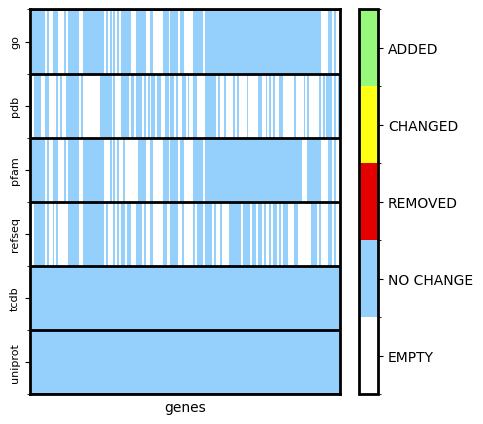

In [9]:
df_annotations = df_model_tcdb.loc[
    :, [annotation_type] + ["tcdb", "uniprot", "pfam", "refseq", "pdb", "go"]
]
# Explode and regroup to reduce duplicate mappings to genes
for col in df_annotations.columns:
    df_annotations = explode_column(df_annotations, name=col, sep=";")

df_annotations = df_annotations.groupby(["genes"], as_index=False).agg(
    lambda x: build_string(sorted(x.dropna().unique()))
)
df_annotations = df_annotations.replace(float("nan"), pd.NA).replace("", pd.NA)
if compare:
    compare_on_index = [annotation_type]
    try:
        df_previous = pd.read_csv(
            annotation_dirpath / f"{annotation_type}_{db_tag}.tsv",
            sep="\t",
            index_col=None,
            dtype=str,
        )
        df_previous = df_previous.replace(float("nan"), pd.NA).replace("", pd.NA)
    except FileNotFoundError:
        df_previous = pd.DataFrame([], columns=compare_on_index)
    df_comparision = compare_tables(
        df_previous.set_index(compare_on_index),
        df_annotations.set_index(compare_on_index),
    )

    fig, ax = plt.subplots(1, 1, figsize=compare_figsize)
    ax.yaxis.set_tick_params(labelsize=8)
    ax = visualize_comparison(df_comparision)

if display_nunique:
    for col in df_annotations.columns:
        df = explode_column(df_annotations, name=col, sep=";")
        df = df[col].drop_duplicates()
        print(f"{df.name}: {df.nunique()}")

if overwrite:
    df_annotations.to_csv(
        annotation_dirpath / f"{annotation_type}_{db_tag}.tsv", sep="\t", index=False
    )
else:
    df_annotations.to_csv(
        ROOT_PATH / INTERIM_PATH / f"{annotation_type}_{db_tag}.tsv",
        sep="\t",
        index=False,
    )
df_annotations